In [38]:
from google.colab import drive
import pandas as pd
import os

# Mount Google Drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [39]:
import re
import nltk
from nltk.corpus import stopwords
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [40]:
# Path to your dataset inside Google Drive
file_path = '/content/drive/My Drive/DL-Assignment/IMDB Dataset.csv'

# Load dataset into a pandas DataFrame
df = pd.read_csv(file_path)

# Check the first few rows
print("Dataset shape:", df.shape)
print(df.head(5))

# Count the number of positive and negative reviews
print("\nSentiment Value Counts:")
print(df['sentiment'].value_counts())

Dataset shape: (50000, 2)
                                              review sentiment
0  One of the other reviewers has mentioned that ...  positive
1  A wonderful little production. <br /><br />The...  positive
2  I thought this was a wonderful way to spend ti...  positive
3  Basically there's a family where a little boy ...  negative
4  Petter Mattei's "Love in the Time of Money" is...  positive

Sentiment Value Counts:
sentiment
positive    25000
negative    25000
Name: count, dtype: int64


In [41]:
!pip install tensorflow

In [42]:
from tensorflow.keras.preprocessing.text import Tokenizer
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.sequence import pad_sequences

In [43]:
# Lowercase
df['review'] = df['review'].str.lower()

# Remove HTML tags
df['review'] = df['review'].apply(lambda x: re.sub(r'<.*?>', '', x))

# Remove punctuation (fixed with raw string)
df['review'] = df['review'].str.replace(r'[^\w\s]', '', regex=True)

# Remove stopwords
stop_words = set(stopwords.words('english'))
df['review'] = df['review'].apply(lambda x: ' '.join([w for w in x.split() if w not in stop_words]))


In [44]:
# Label encoding
df['sentiment'] = df['sentiment'].apply(lambda x: 1 if x=='positive' else 0)

In [45]:
# Extract input features (reviews) and target labels (sentiments)
X = df['review'].values
y = df['sentiment'].values

In [46]:
# Split the dataset into training and testing sets (80% train, 20% test)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [47]:
# Set vocabulary size (top most frequent words)
vocab_size = 10000

# Initialize the tokenizer
tokenizer = Tokenizer(num_words=vocab_size, oov_token="<OOV>")

In [48]:
# Fit tokenizer on training data
tokenizer.fit_on_texts(X_train)

# Convert text to sequences of integers
X_train_seq = tokenizer.texts_to_sequences(X_train)
X_test_seq = tokenizer.texts_to_sequences(X_test)

In [49]:
# Set maximum sequence length
max_len = 200

# Pad sequences
X_train_pad = pad_sequences(X_train_seq, maxlen=max_len, padding='post')
X_test_pad = pad_sequences(X_test_seq, maxlen=max_len, padding='post')

In [50]:
# Display the shapes of the padded training and testing data
print("✅ Training data shape: ", (X_train_pad.shape))
print("✅ Testing data shape:  ", (X_test_pad.shape))

✅ Training data shape:  (40000, 200)
✅ Testing data shape:   (10000, 200)


In [51]:
# Build the CNN Model for Text Classification
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, Conv1D, MaxPooling1D, GlobalMaxPooling1D, Flatten, Dense, BatchNormalization, Dropout
from tensorflow.keras.regularizers import l1_l2
from tensorflow.keras.optimizers import Adam

# Hyperparameters
vocab_size = 10000
embedding_dim = 100
max_len = 200

# Define the model
model = Sequential([
    # Embedding layer: converts words into dense vectors
    Embedding(input_dim=vocab_size, output_dim=embedding_dim, input_length=max_len),

    # First convolutional layer + batch normalization
    Conv1D(filters=128, kernel_size=5, activation='relu',
           kernel_regularizer=l1_l2(l1=0.001, l2=0.001)),
    BatchNormalization(),

    # Second convolutional layer + batch normalization
    Conv1D(filters=128, kernel_size=5, activation='relu',
           kernel_regularizer=l1_l2(l1=0.001, l2=0.001)),
    BatchNormalization(),

    # Third convolutional layer + batch normalization
    Conv1D(filters=128, kernel_size=5, activation='relu',
           kernel_regularizer=l1_l2(l1=0.001, l2=0.001)),
    BatchNormalization(),

    # Max pooling to reduce sequence length
    MaxPooling1D(pool_size=2),

    # Flatten the 3D tensor to 2D for Dense layers
    Flatten(),

    # Fully connected Dense layer with dropout
    Dense(64, activation='relu', kernel_regularizer=l1_l2(l1=0.001, l2=0.001)),
    Dropout(0.5),

    # Output layer for binary classification
    Dense(1, activation='sigmoid')
])

# Compile the model with Adam optimizer and binary crossentropy loss
optimizer = Adam(learning_rate=0.0001)
model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])

/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/embedding.py:97: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


In [52]:
# Compile the model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

In [53]:
# Train the model
history = model.fit(
    X_train_pad,
    y_train,
    epochs=5,
    batch_size=64,
    validation_split=0.1,
    verbose=1
)

Epoch 1/5
563/563 ━━━━━━━━━━━━━━━━━━━━ 274s 480ms/step - accuracy: 0.5184 - loss: 7.9435 - val_accuracy: 0.7745 - val_loss: 1.1887
Epoch 2/5
563/563 ━━━━━━━━━━━━━━━━━━━━ 268s 475ms/step - accuracy: 0.8607 - loss: 0.8326 - val_accuracy: 0.8825 - val_loss: 0.5924
Epoch 3/5
563/563 ━━━━━━━━━━━━━━━━━━━━ 265s 470ms/step - accuracy: 0.9084 - loss: 0.5398 - val_accuracy: 0.8462 - val_loss: 0.6523
Epoch 4/5
563/563 ━━━━━━━━━━━━━━━━━━━━ 328s 482ms/step - accuracy: 0.9299 - loss: 0.4770 - val_accuracy: 0.8830 - val_loss: 0.5771
Epoch 5/5
563/563 ━━━━━━━━━━━━━━━━━━━━ 266s 473ms/step - accuracy: 0.9502 - loss: 0.4033 - val_accuracy: 0.8407 - val_loss: 0.7576


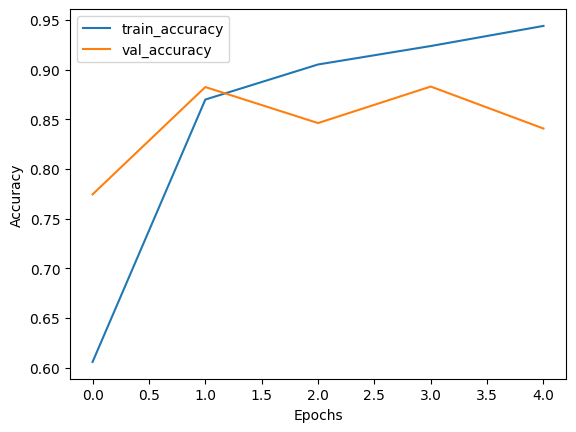

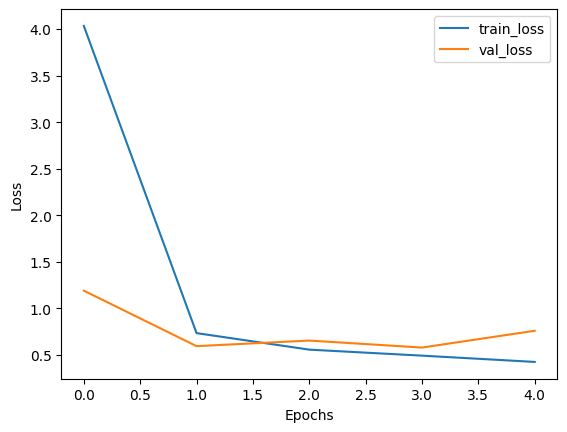

In [54]:
# Plot Training and Validation Loss/Accuracy
import matplotlib.pyplot as plt

# Accuracy plot
plt.plot(history.history['accuracy'], label='train_accuracy')
plt.plot(history.history['val_accuracy'], label='val_accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# Loss plot
plt.plot(history.history['loss'], label='train_loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [55]:
# Model evaluation with metrics
from sklearn.metrics import classification_report, accuracy_score, f1_score, precision_score, recall_score
import numpy as np
import matplotlib.pyplot as plt

# Predict on test set
y_pred = model.predict(X_test_pad)
y_pred_classes = np.argmax(y_pred, axis=1)

# Use original integer labels for true values
y_true_classes = y_test

# Compute accuracy
accuracy = accuracy_score(y_true_classes, y_pred_classes)
print(f'Accuracy: {accuracy:.4f}')

# Compute F1-score, precision, and recall
# Use zero_division=1 to handle cases where a class has no predicted samples
f1 = f1_score(y_true_classes, y_pred_classes, average='weighted', zero_division=1)
precision = precision_score(y_true_classes, y_pred_classes, average='weighted', zero_division=1)
recall = recall_score(y_true_classes, y_pred_classes, average='weighted', zero_division=1)

print(f'F1-Score: {f1:.4f}')
print(f'Precision: {precision:.4f}')
print(f'Recall: {recall:.4f}')

# Classification report for detailed metrics
print(classification_report(y_true_classes, y_pred_classes, zero_division=1))

313/313 ━━━━━━━━━━━━━━━━━━━━ 18s 56ms/step
Accuracy: 0.4961
F1-Score: 0.3290
Precision: 0.7500
Recall: 0.4961
              precision    recall  f1-score   support

           0       0.50      1.00      0.66      4961
           1       1.00      0.00      0.00      5039

    accuracy                           0.50     10000
   macro avg       0.75      0.50      0.33     10000
weighted avg       0.75      0.50      0.33     10000

